In [1]:
import pandas
import itertools
import sklearn 
import seaborn
import matplotlib
import spacy

from tqdm.notebook import tqdm
from IPython.display import display
tqdm.pandas()

from functools import lru_cache, partial
lru_cache = lru_cache(maxsize=None)

%matplotlib inline

In [2]:
nlp = spacy.load("en_core_web_sm")

### Load comment data and rating data

In [3]:
# Load raw dataset of accounts and comments retrieved from GitHub API
df_raw = (
    pandas.read_csv('../rawdata/account_comments.csv.gz', index_col=0)
    .fillna('')
    .assign(comment = lambda x: x['comment'].astype(str))
)
# To have a copy of original dataset
df = df_raw.copy()

In [4]:
df_ratings = pandas.read_csv('../rawdata/accounts_rating_final.csv')

### Tokenizing texts

In [5]:
# spacy tokenizer
def tokenizer(text):
    doc = nlp(text)
    return [t.text for t in doc]

In [ ]:
# Tokenize comments
df = (
    df
    .assign(words=lambda d: d['comment'].progress_apply(lambda c:
        (set() if (type(c) is float) | (c == "") else set(tokenizer(c)) )
    ))
    .reset_index(drop=True) 
)

### Routines

In [ ]:
def compute_distance(items, distance):
    """ 
    Computes a distance matrix for given items, using given distance function.
    """
    m = pandas.np.zeros((len(items), len(items)))
    enumitems = list(enumerate(items))
    for xe, ye in itertools.combinations(enumitems, 2):
        i, x = xe
        j, y = ye
        d = distance(x, y)
        m[i,j] = m[j,i] = d
    return m

In [ ]:
@lru_cache
def jaccard(x, y):
    """
    To tokenize text and compute jaccard disatnce
    """
    x_w = set(tokenizer(x))
    y_w = set(tokenizer(y))
    return len(x_w.symmetric_difference(y_w)) / (len(x_w.union(y_w)) if len(x_w.union(y_w))>0 else 1)

def jaccard_words(x, y):
    """
    Same as above, but on list of words.    
    """
    return len(x.symmetric_difference(y)) / (len(x.union(y)) if len(x.union(y))>0 else 1)

In [ ]:
@lru_cache
def levenshtein(x, y, n=None):
    from Levenshtein import distance as lev
    if n is not None:
        x = x[:n]
        y = y[:n]
    return lev(x, y) / (max(len(x), len(y)) if max(len(x), len(y)) >0 else 1)

In [ ]:
def average_jac_lev(x, y):
    """
    Computes average of jacard and levenshtein for 2 given strings
    """
    return (jaccard(x, y) + levenshtein(x, y)) / 2

### Compute number of clusters

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
parameters = {
    'Jaccard': {'func': jaccard_words, 'source': 'words', 'eps': 0.5},
    'Levenshtein': {'func': levenshtein, 'source': 'comment', 'eps': 0.5},
    'Combined': {'func': average_jac_lev, 'source': 'comment', 'eps': 0.5},
}

In [ ]:
# Using pool and tqdm to calculate clusters 

from multiprocessing import Pool

def task(data):
    user, distance, group, params = data
    
    clustering = DBSCAN(eps=params['eps'], min_samples=1, metric='precomputed')
    items = compute_distance(getattr(group, params['source']), params['func'])
    clusters = clustering.fit_predict(items)
    
    return (
        user, 
        distance, 
        len(group), 
        clusters,
        items,
    )
    
inputs = []
for user, group in df.groupby('account'):
    for distance, params in parameters.items():
        inputs.append((user, distance, group.copy(), params))
        
data = []
with Pool() as pool:
    for result in tqdm(pool.imap_unordered(task, inputs), total=len(inputs)):
        data.append(result)
        
df_clusters = pandas.DataFrame(data=data, columns=['account', 'distance', 'comments', 'labels', 'matrix'])

In [313]:
def gini(x):
    """
    Computes Gini inequality metric for a given array
    """
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = (mad/np.mean(x) if np.mean(x) != 0 else 0)
    g = 0.5 * rmad
    return g

In [314]:
from collections import Counter
np = pandas.np

df_clusters = (
    df_clusters
    .assign(
        clusters=lambda d: d['labels'].apply(lambda s: max(*s) + 1),
        values=lambda d: d['matrix'].apply(lambda s: s[pandas.np.tril(s).astype(bool)]),
    )
    .assign(
        mean=lambda d: d['values'].apply(lambda s: s.mean()),
        gini = lambda d: d['values'].apply(lambda s: gini(s)),
    )
)

/root/.local/share/virtualenvs/botse/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
/root/.local/share/virtualenvs/botse/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/root/.local/share/virtualenvs/botse/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


## Bot vs Human - Jaccard vs Levenshtein

In [ ]:
df_temp = (
    df_ratings.assign(
        bot = lambda x: x['final'].apply(lambda s: ('Bot' if s == 2 else 'Human'))
    )[['id','bot']]
    .merge(
        df_clusters.assign(
            mean = lambda x: x['matrix'].apply(lambda s : s[~pandas.np.eye(s.shape[0], dtype='bool')].mean())
        )[['account','distance','mean']]
        .merge(
            df_raw.drop_duplicates(['account','id'])[['account','id']],
            on='account',
            how='left'
        ),
        on='id',
        how='left'
    )
)

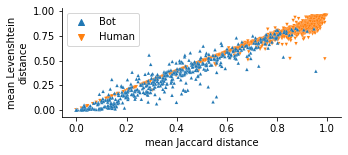

In [331]:
fig, ax = matplotlib.pyplot.subplots(figsize=[5,2])

classes = ["Bot", "Human"]

ax = seaborn.scatterplot(
    data=(
        df_temp[lambda d: d['distance'] == 'Jaccard']
        .merge(
            df_temp[lambda d: d['distance'] == 'Levenshtein'],
            on=['account'], 
            suffixes=('_jaccard', '_levenshtein'),
        )
        .sort_values('bot_jaccard',ascending=False)
    ),
    x='mean_jaccard',
    y='mean_levenshtein',
    hue='bot_jaccard',
    style='bot_jaccard',
    markers=['v','^'],
    hue_order=["Bot", 'Human'],
    s=12,
    linewidth=.1, alpha = 1,
    ax = ax,
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
ax.set_ylabel('mean Levenshtein\ndistance')
ax.set_xlabel('mean Jaccard distance')
fig.savefig('../figures/jaclev_scatter.pdf', bbox_inches='tight')

## Create dataset for classification task

In [315]:
# This dataframe contains the following information: 
#   * id,         -> ID associated to the account in our database
#   * account,         -> account's user login
#   * project,         -> in which project in github
#   * comments,        -> number of comments, 
#   * empty_comments,  -> number of empty comments
#   * clusters,        -> number of comment cluster
#   * gini    -> gini of comments according to combined distance metric

df = (
    df_raw
    .assign(
        comment = lambda x: x['comment'].fillna("")
    )
    .assign(comment = lambda x: x['comment'].astype(str))
    .assign(empty = lambda x: np.where(x['comment'].str.len()==0,1,0) )
    .groupby(['id','account','project'],as_index = False)
    .agg({
        'comment':'count',
        'empty':'sum'
    })
    .merge(
        (
            pandas.pivot_table(
                df_clusters[['account','distance','clusters','gini']],
                values=['clusters','gini'],
                index=['account'],
                columns=['distance']
            )
            .reset_index()
        ),
        on = 'account',
        how = 'left'
    )
)
df.columns = ['id','account','project','comments','empty_comments',
              'clusters','clusters_jaccard','clusters_levenshtein',
              'gini','jaccard_gini','levenshtein_gini']
df = df[['id','account','project','comments','empty_comments','clusters','gini']]

/root/.local/share/virtualenvs/botse/lib/python3.6/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/root/.local/share/virtualenvs/botse/lib/python3.6/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [316]:
# combine two df to have final dataset for classification task
df_ratings.merge(
    df,
    on='id',
    how='left'
).to_csv('../data/accounts_info.csv',index = False)